# Data prep

## This section is to prepare the data into the proper format for time series forecasting using TensorFlow

### There are many ways to architect a ML solution for TS forecasting - this one will use one of the most cutting edge methods LSTM (long/short term memory) models in a sequence to sequence architecture (seq2seq). 

Seq 2 seq is popular in many application surrounding machine translation (english to french, etc..). This makes sense as we will be taking a time series sequence of inputs to predict a time series output of predicted values

For this example, we will be using the Melbourne Daily min tempuratures dataset 
https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

to illustrate how this technique works. Note that there is only one feature and target/label here, but LSTMs take 3D shapes (n_observations, n_timesteps, n_features), and we will only be dealing with 1 element for the features



# Import and prep the data

Using TensorFlow backend.


,date,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


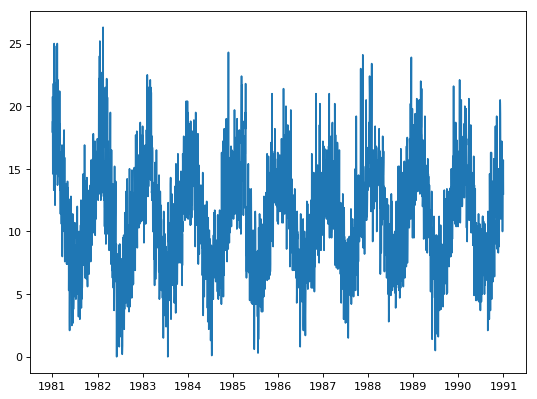

In [1]:
from matplotlib import pyplot as plt
import re
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import keras


%matplotlib inline

pandas_data = pd.read_csv('data/daily-minimum-temperatures-in-me.csv', sep=';', encoding='utf-8' )

columns = ['date', 'temp']

pandas_data.columns = columns

pandas_data['date'] = pd.to_datetime(pandas_data['date'])

pandas_data['temp'] = pandas_data['temp'].str.extract('(\d+.\d)', expand=False) #funky characters in data

pandas_data['temp'] = pandas_data['temp'].astype('float32')

pandas_data['temp'] = pandas_data['temp'].apply(lambda x: round(x,1)) #fp conversion created some noise
 
    
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(pandas_data['date'],pandas_data['temp'])


# pyplot.show
pandas_data.head(10)

In [2]:
pandas_np = pandas_data['temp'].values

dates = pandas_data['date'].values

nobs = pandas_np.shape[0]

train_obs = int(0.75 * nobs)

# we need to create a function that reshapes the data to have each observation as a time series
# and each prediction as a time series
# inspiration here: https://stackoverflow.com/questions/21229503/creating-an-numpy-matrix-with-a-lag

def lagLead4LSTM(arr, window, axis=-1):
    """
    return a running view of length 'window' over 'axis'
    the returned array has an extra last dimension, which spans the window
    """
    shape = list(arr.shape)
    shape[axis] -= (window-1)
    assert(shape[axis]>0)
    return np.lib.index_tricks.as_strided(
        arr,
        shape + [window],
        arr.strides + (arr.strides[axis],))

lag = 90
lead = 30

x1  = lagLead4LSTM(pandas_np, lag)

x = x1[:-lead,] # get rid of last observations with no lags
    

In [3]:


pandas_np.shape, x1.shape, x.shape, pandas_np[lag-1:,].shape


((3650,), (3561, 90), (3531, 90), (3561,))

In [4]:
y = lagLead4LSTM(pandas_np[lag:,],lead) 

print(x[4], y[3]) 
#last element should be same as first (tommorows data = first datapoint in y)

"the shapes for x are: {} and the shapes for y are: {}".format(x.shape, y.shape)

[15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7 21.5 25.  20.7 20.6 24.8
 17.7 15.5 18.2 12.1 14.4 16.  16.5 18.7 19.4 17.2 15.5 15.1 15.4 15.3
 18.8 21.9 19.9 16.6 16.8 14.6 17.1 25.  15.  13.7 13.9 18.3 22.  22.1
 21.2 18.4 16.6 16.1 15.7 16.6 16.5 14.4 14.4 18.5 16.9 17.5 21.2 17.8
 18.6 17.  16.  13.3 14.3 11.4 16.3 16.1 11.8 12.2 14.7 11.8 11.3 10.6
 11.7 14.2 11.2 16.9 16.7  8.1  8.   8.8 13.4 10.9 13.4 11.  15.  15.7
 14.5 15.8 16.7 16.8 17.5 17.1] [17.1 18.1 16.6 10.  14.9 15.9 13.   7.6 11.5 13.5 13.  13.3 12.1 12.4
 13.2 13.8 10.6  9.  10.   9.8 11.5  8.9  7.4  9.9  9.3  9.9  7.4  8.6
 11.9 14. ]


'the shapes for x are: (3531, 90) and the shapes for y are: (3531, 30)'

# The data is now in the shape for us to to a seq2seq model
## We are using the last 30 days to predict the next 7 days

First, we need to split the data and scale it on a 0-1

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(pandas_np.reshape(-1,1))

pandas_np_scaled = scaler.transform(pandas_np.reshape(-1,1))

pandas_np_scaled

trainN = int(0.75 * pandas_np_scaled.shape[0]) # will take only the first 75 percent days

trainRaw = pandas_np_scaled[:trainN,-1]

testRaw = pandas_np_scaled[trainN+1:,-1]

trainDates = dates[:trainN]

testDates = dates[trainN+1:]

In [6]:
"The number of train cases are {} days, test cases are {} days".format(trainRaw.shape[0], testRaw.shape[0])

'The number of train cases are 2737 days, test cases are 912 days'

In [7]:
#reapply the transform above now we are split and scaled
lag = 90
lead = 30

def reshapeDataXY(rawData, lag=lag, lead=lead):
    x = lagLead4LSTM(rawData, lag)
    x = x[:-lead,]
    xs1, xs2 = x.shape
    x = x.reshape(xs1, xs2, 1) #need 1 for the one feature
    y = lagLead4LSTM(rawData[lag:,],lead) 
    ys1, ys2 = y.shape
    y = y.reshape(ys1, ys2, 1)
    return x, y


xTrain, yTrain = reshapeDataXY(trainRaw)
xTest, yTest = reshapeDataXY(testRaw)

# create padded input target sequence
decodeY = np.zeros((yTrain.shape))
decodeY[:,1:,:] = yTrain[:,:-1,:]
# print(yTrain[2])
# print(decodeY[2])

In [8]:
print(xTrain.shape, yTrain.shape, decodeY.shape)

(2618, 90, 1) (2618, 30, 1) (2618, 30, 1)


# Now to setup the LSTM seq2seq model
from: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

Here is an example of the architecture in the context of machine translation:

![](https://blog.keras.io/img/seq2seq/seq2seq-inference.png)

An excellent explanation of GRUs and LSTMs are here

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

![](https://cdn-images-1.medium.com/max/1600/1*VOXRGhOShoWWks6ouoDN3Q.gif)

In [9]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RNN


latent_dim = 256

num_encoder_tokens = 1
num_decoder_tokens = 1

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 264192      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  264192      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [10]:
# Run training

batch_size = 512
epochs = 10

#research - forced teaching (shifted by one input for decoder) does not perform well
decodeY = np.zeros(decodeY.shape)

learning_rate = 0.01
decay = 1e-7 # Learning rate decay
beta2 = .90

optimizer = keras.optimizers.Adam(lr=learning_rate, decay=decay, beta_2=beta2)

model.compile(optimizer=optimizer, loss='mean_absolute_error')
history = model.fit([xTrain, decodeY], yTrain,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=.05)

Train on 2487 samples, validate on 131 samples
Epoch 1/10
2487/2487 [==============================] - 9s 4ms/step - loss: 0.2660 - val_loss: 0.2228
Epoch 2/10
2487/2487 [==============================] - 7s 3ms/step - loss: 0.2376 - val_loss: 0.2033
Epoch 3/10
2487/2487 [==============================] - 6s 2ms/step - loss: 0.3408 - val_loss: 0.2324
Epoch 4/10
2487/2487 [==============================] - 6s 2ms/step - loss: 0.2429 - val_loss: 0.2621
Epoch 5/10
2487/2487 [==============================] - 6s 3ms/step - loss: 0.2408 - val_loss: 0.2087
Epoch 6/10
2487/2487 [==============================] - 6s 2ms/step - loss: 0.2390 - val_loss: 0.2358
Epoch 7/10
2487/2487 [==============================] - 6s 3ms/step - loss: 0.2372 - val_loss: 0.2244
Epoch 8/10
2487/2487 [==============================] - 7s 3ms/step - loss: 0.2315 - val_loss: 0.1949
Epoch 9/10
2487/2487 [==============================] - 6s 3ms/step - loss: 0.2354 - val_loss: 0.2368
Epoch 10/10
2487/2487 [============

In [13]:
decoder_lstm

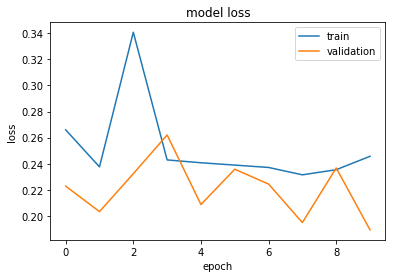

In [11]:
# summarize history for accuracy
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

# Inference setup 


In [12]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [16]:
def decode_sequence(x, length_forecast=7):
    # Encode the input as state vectors.
    y_pred = []
    
    
    decoder_input = np.zeros((1, x.shape[0], 1))
    
    states = encoder_model.predict(x)
    
    for _ in range(length_forecast):
#         output, h, c = decoder_model.predict(
#             [decoder_input] + states)
        outputs_and_states = decoder_model.predict(
                [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]
        
        y_pred.append(output)

         # Update states
        #states = [h, c]


    return np.concatenate(y_pred, axis=1)

NameError: name 'encoder_model' is not defined

In [ ]:
#print random plots for every 1000 steps
import matplotlib.dates as mdates

step = 30
offset = 365
prediction_time = 30


date_idx1 = trainN + 1 + offset - lag

date_idx2 = date_idx1 + lag + prediction_time


for i in range(10):
    
    dates = pandas_data['date'][date_idx1+i: date_idx2+i]
    dates1 = pd.to_datetime(dates, unit='s')
    dates1 = [mdates.date2num(d) for d in dates1]

    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    test_line = i * step + offset

    xLine = xTest[test_line,:]
    yLine = yTest[test_line,:]

    xLine = xLine.reshape(1, lag, 1)
    yHat = decode_sequence(xLine, prediction_time)
    hist = np.vstack((xLine.reshape(lag, 1), -1*np.ones(yLine.shape)))
    hist = scaler.inverse_transform(hist)*9/5 + 32
    hist[hist == 32] = np.nan

    plt.plot(dates1, hist)
    preds = np.vstack((-1*np.ones((lag, 1)), yHat[0,:]))
    preds = scaler.inverse_transform(preds)*9/5 + 32
    preds[preds == 32] = np.nan

    plt.plot(dates1, preds)
    acts = np.vstack((-1*np.ones((lag, 1)),yLine))
    acts = scaler.inverse_transform(acts)*9/5 + 32
    acts[acts == 32] = np.nan

    plt.plot(dates1, acts)
    plt.legend(['historic', 'predicted', 'actual'], loc='lower left')
    ax = plt.axes()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    print("Actual, Predicted Values:")
    for i, j in zip(yLine.flatten(), yHat.flatten()):
        i = scaler.inverse_transform(i)*9/5 + 32
        j = scaler.inverse_transform(j)*9/5 + 32
        i = i.flatten()[0]
        j = j.flatten()[0]
        print(i,",", j)
    plt.show()


In [16]:
encoder_model.save('models/LSTMencoder.h5')
decoder_model.save('models/LSTMdecoder.h5')

/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
